In [156]:
from pathlib import Path

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

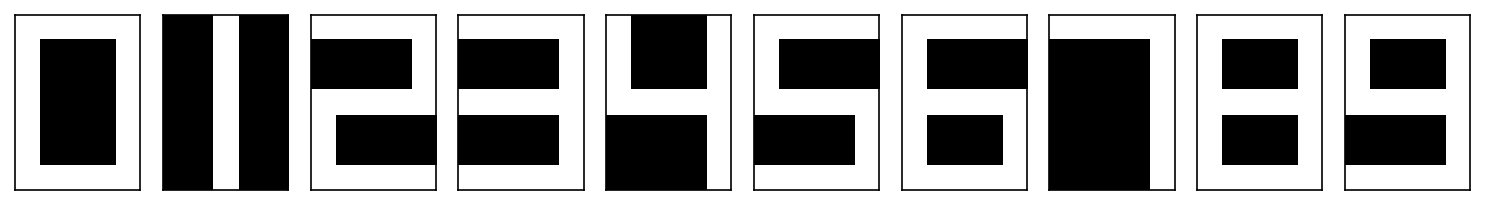

In [157]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [158]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [159]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

In [160]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

In [161]:
@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def d_relu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def d_sigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [162]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, U: np.ndarray, d:np.ndarray, V: np.ndarray, c:np.ndarray, W: np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dU = np.zeros(U.shape)
    dd = np.zeros(d.shape)

    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    h = np.zeros((U.shape[0], U.shape[1]))
    
    for i in range(x_batch.shape[0]):
        z = x_batch[i].copy()

        for j in range(U.shape[0]):
            h[j] = U[j] @ x_batch[i] + d[j]
            z += V[j] @ relu(h[j]) + c[j]

        y = softmax(W @ z + b)

        dLdy = y - y_batch[i]
        dLdz = W.T @ dLdy
        
        for j in range(U.shape[0]):
            dLdh = V[j].T @ dLdz * d_relu(h[j])

            dU[j] += np.outer(dLdh, x_batch[i])
            dd[j] += dLdh
        
        for j in range(V.shape[0]):
            dV[j] += np.outer(dLdz, relu(h[j]))
            dc[j] += dLdz
        
        dW += np.outer(dLdy, z)
        db += dLdy
    
    return (dU, dd, dV, dc, dW, db)

class RadialPerceptron:
    def __init__(self, n_layers:int, n_hidden:int, n_in:int, n_out:int) -> None:
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_in = n_in
        self.n_out = n_out
                
        self.U: np.ndarray = np.random.uniform(-1, 1, (n_layers, n_hidden, n_in))
        self.d: np.ndarray = np.zeros((n_layers, n_hidden))

        self.V: np.ndarray = np.random.uniform(-1, 1, (n_layers, n_in, n_hidden))
        self.c: np.ndarray = np.zeros((n_layers, n_in))

        self.W: np.ndarray = np.random.uniform(-1, 1, (n_out, n_in))
        self.b: np.ndarray = np.zeros(n_out)
        

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = x.copy()
        
        for i in range(self.U.shape[0]):
            h = relu(self.U[i] @ x + self.d[i])
            z += self.V[i] @ h + self.c[i]
                    
        return softmax(self.W @ z + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        y_pred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(y_pred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n_batches):
                ibegin, iend = batch_idx * batch_size, min((batch_idx + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]
            
                dU, dd, dV, dc, dW, db = grads(
                    x_train[batch_idxs],
                    y_train[batch_idxs],
                    self.U,
                    self.d,
                    self.V,
                    self.c,
                    self.W,
                    self.b
                )
                
                self.U -= lr * dU
                self.d -= lr * dd

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

In [163]:
n_layers = 5
n_hidden = 7
n_in = 35
n_out = 10

learning_rate = 1e-2
batch_size = 16
max_epoch = 256

model = RadialPerceptron(n_layers, n_hidden, n_in, n_out)

print('untrained loss: ', model.loss(x_test, y_test).round(6))

model.train(
    x_train,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(6))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  2.145886
trained loss:  0.001138
test set accuracy: 100.0%


In [168]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 71.07%


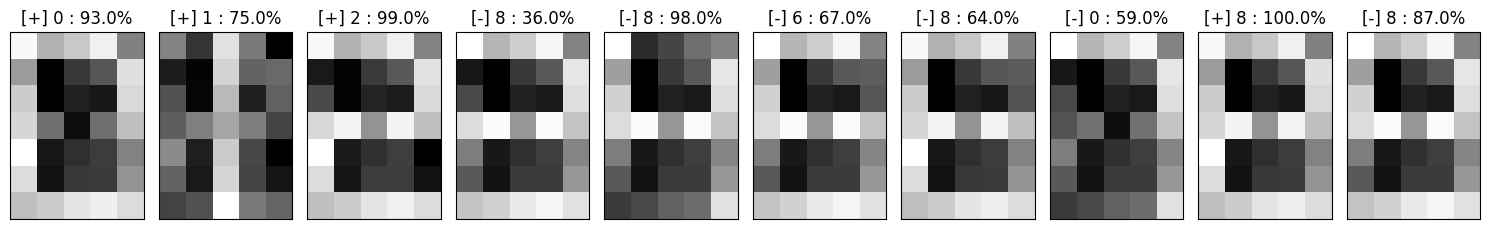

In [169]:
noise_size = 1.0

x_noised = data_mtrx + np.random.uniform(0.0, noise_size, img_size)
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(y[i])

    ax.set_title(f"[{'+' if j == i else '-'}] {j} : {(y[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()